##<font color='moccasin'>`NB SETUP`</font>

####<font color='salmon'>`INSTALLS`</font>

In [1]:
# HuggingFace Vision Datasets Library
!pip install datasets[vision] gwpy &> /dev/null

In [ ]:
# Model Library
!pip install timm gwpy &> /dev/null

In [ ]:
import timm

In [ ]:
# Fast.ai
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *

####<font color='salmon'>`IMPORTS`</font>

In [ ]:
# PIL: 'Python Image Library'
from PIL import Image 

# File Handling
import os
import tarfile
from pathlib import Path 

import torch
import numpy as np

##<font color='moccasin'>`IMAGE DATASET IMPORTS`</font>

Dataset Methods:

- `dataset.features`
- `dataset.shape`
- `dataset.cache_files`
- `dataset.num_columns`
- `dataset.num_rows`

In [2]:
from datasets import load_dataset 
from datasets import get_dataset_infos

####<font color='salmon'>`FASHION MNIST (**LOAD THIS ONE**)`</font> 


https://huggingface.co/datasets/fashion_mnist

- Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

In [3]:
fashion_mnist = load_dataset("fashion_mnist")

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
fashion_mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [22]:
# Check example image
fashion_mnist['train'][0]['image']

####<font color='salmon'>`COCO SAMPLE`</font> 


https://cocodataset.org/#home
- ** From Fast.ai datasets module
- Unknown images

In [ ]:
fastai_cfg()

In [ ]:
coco_sample = untar_data(URLs.COCO_SAMPLE)
coco_sample.ls()

(#2) [Path('/root/.fastai/data/coco_sample/annotations'),Path('/root/.fastai/data/coco_sample/train_sample')]

In [ ]:
# Makes the ls() contents printout relative to the 'path' folder
Path.BASE_PATH = coco_sample
# Show folder contents
coco_sample.ls()

(#2) [Path('annotations'),Path('train_sample')]

In [ ]:
# Look inside sub-folder
(coco_sample/'train_sample').ls()

(#21837) [Path('train_sample/000000407975.jpg'),Path('train_sample/000000297131.jpg'),Path('train_sample/000000351622.jpg'),Path('train_sample/000000045356.jpg'),Path('train_sample/000000221515.jpg'),Path('train_sample/000000366643.jpg'),Path('train_sample/000000101781.jpg'),Path('train_sample/000000347866.jpg'),Path('train_sample/000000318594.jpg'),Path('train_sample/000000520278.jpg')...]

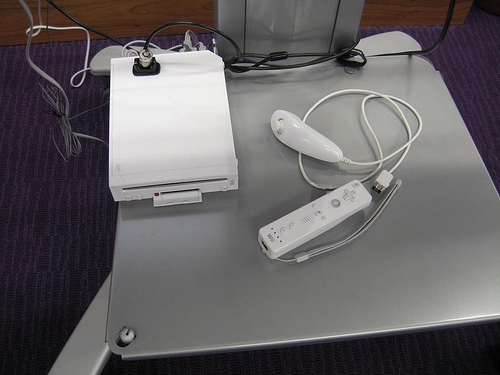

In [ ]:
# Grab sample image
coco_im = Image.open('/root/.fastai/data/coco_sample/train_sample/000000407975.jpg')

# Display
coco_im

####<font color='salmon'>`FOOD 101`</font> 


https://huggingface.co/datasets/food101

- 101 Food Classes
- 101,000 images?

In [ ]:
food101 = load_dataset("food101")

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
food101.features

####<font color='salmon'>`IMAGENET 1K`</font> 


https://huggingface.co/datasets/imagenet-1k
- 1K Classes
- train: 1,281,167 - Val: 50,000 - test: 100,000

In [ ]:
imagenet1k = load_dataset("imagenet-1k")

####<font color='salmon'>`IMAGENET SKETCH`</font> 


In [ ]:
imagenet_sketch = load_dataset("imagenet_sketch")

https://huggingface.co/datasets/imagenet_sketch
- Drawing counterpart images for every class in ImageNet1K
- ≈ 50 images/ class

####<font color='salmon'>`COCO`</font>

https://cocodataset.org/#home


####<font color='salmon'>`OPEN IMAGES-V6`</font>

##<font color='moccasin'>`IMAGE PROCESSING`</font>

In [ ]:
import scipy
import h5py
import skimage
from skimage.color import rgb2gray
from skimage import color
import torch
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
#import timm
import numpy as np
import io
from PIL import Image, ImageOps
from skimage import measure
from matplotlib import pyplot as plt
from skimage import filters

In [ ]:
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/942 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def process_image(image):
    # prepare image for the model
    encoding = feature_extractor(image, return_tensors="pt")

    # forward pass
    with torch.no_grad():
        outputs = model(**encoding)
        predicted_depth = outputs.predicted_depth

    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    output = prediction.cpu().numpy()
    formatted = (output * 255 / np.max(output)).astype('uint8')
    img = Image.fromarray(formatted)
    return img

    return result

C:\Users\Nikolai\anaconda3\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


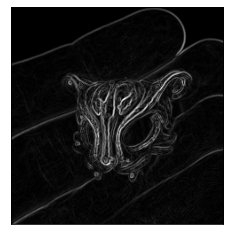

In [ ]:
images = [Image.open(x) for x in ['catmask.jpg']]
iterator = 1
for i in images:
    widths, heights = i.size
    total_width = widths*2
    max_height = heights*2
    new_im = Image.new('RGBA', (total_width, max_height))
    grey = rgb2gray(i)
    edge_sobel = filters.sobel(grey)
    fig = plt.imshow(edge_sobel, cmap=plt.cm.gray)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png',bbox_inches='tight')
    im = Image.open(img_buf).resize(size=(widths, heights))
    Img = i.convert("RGBA")
    g = ImageOps.grayscale(i)
    grayRGB = ImageOps.colorize(g, black="black", white="white").convert("RGBA")
    depth_img = process_image(i)

    new_im.paste(Img, (0,0))
    new_im.paste(grayRGB, (widths,0))
    new_im.paste(im, (0,heights))
    new_im.paste(depth_img, (widths,heights))
    new_im.save('test.png')
    img_buf.close()